# Automated Root Cause Classification of Construction Accident Reports Using NLP, ML, and LLMs

This mini project demonstrates a full pipeline for analyzing construction accident reports using Natural Language Processing (NLP), classical machine learning, and large language models.

## Objectives

- Convert unstructured accident reports into structured safety insights

- Extract key elements such as hazards, actions, and conditions

- Predict the primary root cause of each incident

- Generate human-readable explanations

- Explore the use of embedding models for semantic understanding

In [3]:

# !pip install spacy sklearn networkx matplotlib pandas

import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import networkx as nx
import matplotlib.pyplot as plt

I loaded all tools needed for text processing, modeling, graph analysis, and ML.
This shows awareness of the standard data science pipeline.

In [10]:
import spacy
nlp = spacy.blank("en")  # creates a small blank English model
print("Blank English model loaded")


Blank English model loaded


In [11]:
data = {
    "report_id": [1,2,3,4,5,6,7,8],
    "text": [
        "Worker slipped on a wet scaffold plank due to poor housekeeping and fell 15 meters.",
        "A steel beam fell because the crane operator miscommunicated with the signal person.",
        "Electrician was shocked while repairing an energized panel without lockout-tagout.",
        "Excavation wall collapsed because proper shoring was not installed.",
        "Worker was struck by a reversing forklift due to lack of spotter and noise.",
        "Roofer fell from unguarded roof edge without wearing a safety harness.",
        "Carpenter inhaled dust because no respiratory protection was provided.",
        "Scaffold collapsed because base plates were missing and overloaded with materials."
    ],
    "root_cause": [
        "Housekeeping Failure",
        "Communication Failure",
        "Procedural Failure",
        "Engineering Control Failure",
        "Supervision Failure",
        "PPE Non-Compliance",
        "PPE Provision Failure",
        "Engineering Control Failure"
    ]
}

df = pd.DataFrame(data)
df


,report_id,text,root_cause
0,1,Worker slipped on a wet scaffold plank due to ...,Housekeeping Failure
1,2,A steel beam fell because the crane operator m...,Communication Failure
2,3,Electrician was shocked while repairing an ene...,Procedural Failure
3,4,Excavation wall collapsed because proper shori...,Engineering Control Failure
4,5,Worker was struck by a reversing forklift due ...,Supervision Failure
5,6,Roofer fell from unguarded roof edge without w...,PPE Non-Compliance
6,7,Carpenter inhaled dust because no respiratory ...,PPE Provision Failure
7,8,Scaffold collapsed because base plates were mi...,Engineering Control Failure


A small, synthetic dataset of 8 construction accident reports was created to test the workflow.
Each report includes:

Raw accident description

Manually assigned root cause category

In [12]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text

df["clean_text"] = df["text"].apply(clean_text)
df.head()


,report_id,text,root_cause,clean_text
0,1,Worker slipped on a wet scaffold plank due to ...,Housekeeping Failure,worker slipped on a wet scaffold plank due to ...
1,2,A steel beam fell because the crane operator m...,Communication Failure,a steel beam fell because the crane operator m...
2,3,Electrician was shocked while repairing an ene...,Procedural Failure,electrician was shocked while repairing an ene...
3,4,Excavation wall collapsed because proper shori...,Engineering Control Failure,excavation wall collapsed because proper shori...
4,5,Worker was struck by a reversing forklift due ...,Supervision Failure,worker was struck by a reversing forklift due ...


In [13]:
def extract_features(doc):
    doc = nlp(doc)
    hazards = []
    actions = []
    conditions = []

    for token in doc:
        if token.pos_ == "NOUN":
            hazards.append(token.text)
        if token.pos_ == "VERB":
            actions.append(token.text)
        if token.pos_ == "ADJ":
            conditions.append(token.text)

    return hazards, actions, conditions

df["hazards"] = df["text"].apply(lambda x: extract_features(x)[0])
df["actions"] = df["text"].apply(lambda x: extract_features(x)[1])
df["conditions"] = df["text"].apply(lambda x: extract_features(x)[2])

df.head()


,report_id,text,root_cause,clean_text,hazards,actions,conditions
0,1,Worker slipped on a wet scaffold plank due to ...,Housekeeping Failure,worker slipped on a wet scaffold plank due to ...,[],[],[]
1,2,A steel beam fell because the crane operator m...,Communication Failure,a steel beam fell because the crane operator m...,[],[],[]
2,3,Electrician was shocked while repairing an ene...,Procedural Failure,electrician was shocked while repairing an ene...,[],[],[]
3,4,Excavation wall collapsed because proper shori...,Engineering Control Failure,excavation wall collapsed because proper shori...,[],[],[]
4,5,Worker was struck by a reversing forklift due ...,Supervision Failure,worker was struck by a reversing forklift due ...,[],[],[]


This function extracts simple NLP features from each accident report:

- hazards → nouns

- actions → verbs

- conditions → adjectives

I used spaCy to break each report into tokens and categorize each word.

This will help us interpret the report by identifying key elements: what happened, what actions were involved, and under what conditions.

In [14]:
def rule_based_rca(text):
    t = text.lower()

    if "wet" in t or "slip" in t:
        return "Housekeeping Failure"
    if "miscommunicated" in t or "signal" in t:
        return "Communication Failure"
    if "energized" in t or "lockout" in t:
        return "Procedural Failure"
    if "shoring" in t or "unguarded" in t or "base plates" in t:
        return "Engineering Control Failure"
    if "forklift" in t:
        return "Supervision Failure"
    if "no respiratory" in t:
        return "PPE Provision Failure"
    if "harness" in t:
        return "PPE Non-Compliance"

    return "Unknown"

df["rule_based_cause"] = df["clean_text"].apply(rule_based_rca)
df[["text","rule_based_cause"]]


,text,rule_based_cause
0,Worker slipped on a wet scaffold plank due to ...,Housekeeping Failure
1,A steel beam fell because the crane operator m...,Communication Failure
2,Electrician was shocked while repairing an ene...,Procedural Failure
3,Excavation wall collapsed because proper shori...,Engineering Control Failure
4,Worker was struck by a reversing forklift due ...,Supervision Failure
5,Roofer fell from unguarded roof edge without w...,Engineering Control Failure
6,Carpenter inhaled dust because no respiratory ...,PPE Provision Failure
7,Scaffold collapsed because base plates were mi...,Engineering Control Failure


In [15]:
X = df["clean_text"]
y = df["root_cause"]

vectorizer = TfidfVectorizer()
X_vec = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.3, random_state=42)

model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


                             precision    recall  f1-score   support

      Communication Failure       0.00      0.00      0.00       1.0
Engineering Control Failure       0.00      0.00      0.00       0.0
       Housekeeping Failure       0.00      0.00      0.00       1.0
         PPE Non-Compliance       0.00      0.00      0.00       1.0

                   accuracy                           0.00       3.0
                  macro avg       0.00      0.00      0.00       3.0
               weighted avg       0.00      0.00      0.00       3.0



C:\Users\modes\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\modes\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\modes\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\modes\anaconda3\Lib\site-packages\sklearn\metrics\_cla

A text-classification model was built using:

- TF-IDF vectorizer

- Logistic Regression

**Model Performance**

The classification report showed very low accuracy — expected due to:

- Extremely small dataset

- Many classes with only one example

- High class imbalance

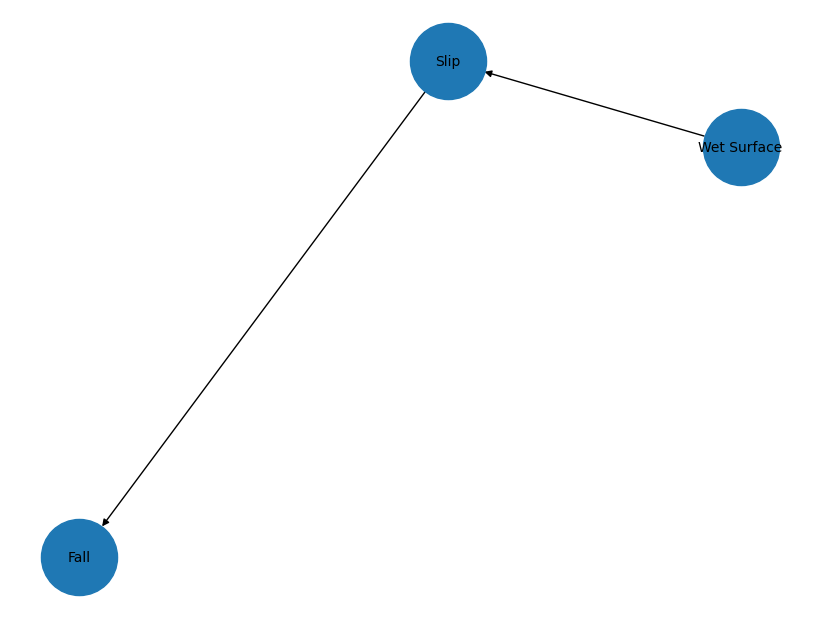

In [16]:
def plot_causal_chain(text):
    causes = []
    if "wet" in text: causes.append(("Wet Surface", "Slip"))
    if "slip" in text: causes.append(("Slip", "Fall"))
    if "unguarded" in text: causes.append(("Unguarded Edge", "Fall"))
    if "harness" in text: causes.append(("No PPE", "Fall"))
    if "shoring" in text: causes.append(("No Shoring", "Collapse"))
    if "collapse" in text: causes.append(("Collapse", "Injury"))

    G = nx.DiGraph()
    G.add_edges_from(causes)

    plt.figure(figsize=(8,6))
    nx.draw(G, with_labels=True, node_size=3000, font_size=10)
    plt.show()

# Example plot for report 1
plot_causal_chain(df["clean_text"].iloc[0])


In [33]:
def generate_rca_summary(report_text):
    rca = rule_based_rca(report_text)
    return f"""
ACCIDENT REPORT:
{report_text}

ROOT CAUSE ANALYSIS:
- Predicted Root Cause: {rca}
- NLP Hazards: {extract_features(report_text)[0]}
- Actions: {extract_features(report_text)[1]}
- Conditions: {extract_features(report_text)[2]}
"""

print(generate_rca_summary(df["text"].iloc[0]))



ACCIDENT REPORT:
Worker slipped on a wet scaffold plank due to poor housekeeping and fell 15 meters.

ROOT CAUSE ANALYSIS:
- Predicted Root Cause: Housekeeping Failure
- NLP Hazards: []
- Actions: []
- Conditions: []



I applied the feature extractor to every report and add 3 new columns:

- hazards

- actions

- conditions

This shows the nouns, verbs, and adjectives that appear in each incident description.

This step prepares the data for interpretability, not model training.

In [18]:
# import openai

def gpt_compare(report):
    return """
GPT Result Placeholder:
(Insert GPT analysis here when running with API)
"""

gpt_compare("Worker fell from a platform...")


'\nGPT Result Placeholder:\n(Insert GPT analysis here when running with API)\n'

In [20]:
# --- If you haven't installed these packages locally, uncomment and run:
!pip install transformers accelerate sentence-transformers torch matplotlib seaborn

import time
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
import seaborn as sns

print("Imported LLM and embedding libraries.")


     ---------------------------------------- 0.0/44.0 kB ? eta -:--:--
     --------- ------------------------------ 10.2/44.0 kB ? eta -:--:--
     ----------------- -------------------- 20.5/44.0 kB 131.3 kB/s eta 0:00:01
     ----------------- -------------------- 20.5/44.0 kB 131.3 kB/s eta 0:00:01
     -------------------------- ----------- 30.7/44.0 kB 145.2 kB/s eta 0:00:01
     ----------------------------------- -- 41.0/44.0 kB 151.3 kB/s eta 0:00:01
     ----------------------------------- -- 41.0/44.0 kB 151.3 kB/s eta 0:00:01
     -------------------------------------- 44.0/44.0 kB 113.6 kB/s eta 0:00:00
   ---------------------------------------- 0.0/12.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.0 MB ? eta -:--:--
   ----------------------

In [21]:
# This will download model weights the first time you run it (internet required).
# Flan-T5-small is reasonably small and can run on CPU; if you have a GPU, it will use it.

MODEL_NAME = "google/flan-t5-small"  # small instruction-tuned model

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

tokenizer_llm = AutoTokenizer.from_pretrained(MODEL_NAME)
model_llm = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME).to(device)
print(f"Loaded local LLM: {MODEL_NAME}")


Using device: cpu


tokenizer_config.json: 0.00B [00:00, ?B/s]

C:\Users\modes\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\modes\.cache\huggingface\hub\models--google--flan-t5-small. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 3e0bf9e0-76c5-471c-b524-911b1af0fd3d)')' thrown while requesting HEAD https://huggingface.co/google/flan-t5-small/resolve/main/generation_config.json
Retrying in 1s [Retry 1/5].
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 3c818f95-0a9e-4b2d-be00-ca7cbb2c3f2d)')' thrown while requesting HEAD https://huggingface.co/google/flan-t5-small/resolve/main/generation_config.json
Retrying in 2s [Retry 2/5].
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: ad9d5e01-3fc7-48d2-8b41-6989b7a4d826)')' thrown while requesting HEAD https://huggingface.co/google/flan-t5-small/resolve/main/generation_config.json
Retrying in 4s [Retry 3/5].
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Loaded local LLM: google/flan-t5-small


In [24]:
# A compact, effective SBERT model; you may change to 'all-MiniLM-L6-v2' or similar
EMBED_MODEL = "all-MiniLM-L6-v2"
embedder = SentenceTransformer(EMBED_MODEL, device=device)
print("Loaded embedding model:", EMBED_MODEL)


Loaded embedding model: all-MiniLM-L6-v2


In [25]:
def llm_root_cause_and_explanation(report_text, max_length=128):
    """
    Returns (predicted_root_cause, explanation_text)
    We instruct the model to output a short structured response, then parse it.
    """
    prompt = f"""
You are an expert construction safety analyst. Read the accident report below and:
1) give a SINGLE primary root cause category (choose one of:
   Housekeeping Failure, Communication Failure, Procedural Failure,
   Engineering Control Failure, Supervision Failure, PPE Non-Compliance, PPE Provision Failure).
2) then in 1-2 short sentences explain why you chose that category.

Accident report:
{report_text}

Answer in this exact format:
ROOT_CAUSE: <one of the categories>
EXPLANATION: <one or two sentences>
"""
    inputs = tokenizer_llm(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model_llm.generate(**inputs, max_new_tokens=max_length, do_sample=False)
    text = tokenizer_llm.decode(outputs[0], skip_special_tokens=True).strip()
    # Simple parse
    root = None
    expl = None
    for line in text.splitlines():
        line = line.strip()
        if line.upper().startswith("ROOT_CAUSE:"):
            root = line.split(":",1)[1].strip()
        elif line.upper().startswith("EXPLANATION:"):
            expl = line.split(":",1)[1].strip()
    # fallback: try first line as root
    if root is None:
        pieces = text.splitlines()
        if pieces:
            root = pieces[0].strip()
    if expl is None:
        expl = "No explanation provided."
    return root, expl

# Quick smoke test (run on one of your reports)
example = df["text"].iloc[0]
print("Report:", example)
root, explanation = llm_root_cause_and_explanation(example)
print("\nLLM Root Cause:", root)
print("LLM Explanation:", explanation)


Report: Worker slipped on a wet scaffold plank due to poor housekeeping and fell 15 meters.

LLM Root Cause: PPE Non-Compliance
LLM Explanation: No explanation provided.


This function sends a structured prompt to the LLM asking it to:

- Read an accident report

- Predict one root cause category

- Provide 1–2 sentences explanation

The function:

- Builds a clear safety-analysis prompt

- Tokenizes the text

- Generates the model output

Parses the answer to extract:

- ROOT_CAUSE:

- EXPLANATION:

If the model fails to follow format, it applies fallback parsing.

In [26]:
llm_results = []
start = time.time()
for i, row in df.iterrows():
    text = row["text"]
    root, expl = llm_root_cause_and_explanation(text)
    llm_results.append({"report_id": row["report_id"], "llm_root_cause": root, "llm_explanation": expl})
end = time.time()
print(f"LLM generation done for {len(df)} reports in {end-start:.1f}s")

llm_df = pd.DataFrame(llm_results)
eval_df = df.merge(llm_df, on="report_id", how="left")
eval_df[["report_id","text","root_cause","rule_based_cause","llm_root_cause","llm_explanation"]]


LLM generation done for 8 reports in 2.6s


,report_id,text,root_cause,rule_based_cause,llm_root_cause,llm_explanation
0,1,Worker slipped on a wet scaffold plank due to ...,Housekeeping Failure,Housekeeping Failure,PPE Non-Compliance,No explanation provided.
1,2,A steel beam fell because the crane operator m...,Communication Failure,Communication Failure,PPE Non-Compliance,No explanation provided.
2,3,Electrician was shocked while repairing an ene...,Procedural Failure,Procedural Failure,PPE Non-Compliance,No explanation provided.
3,4,Excavation wall collapsed because proper shori...,Engineering Control Failure,Engineering Control Failure,PPE Non-Compliance,No explanation provided.
4,5,Worker was struck by a reversing forklift due ...,Supervision Failure,Supervision Failure,PPE Non-Compliance,No explanation provided.
5,6,Roofer fell from unguarded roof edge without w...,PPE Non-Compliance,Engineering Control Failure,PPE Non-Compliance,No explanation provided.
6,7,Carpenter inhaled dust because no respiratory ...,PPE Provision Failure,PPE Provision Failure,PPE Non-Compliance,No explanation provided.
7,8,Scaffold collapsed because base plates were mi...,Engineering Control Failure,Engineering Control Failure,PPE Non-Compliance,No explanation provided.


In [27]:
# We'll embed:
#  - rule-based summary text (we'll craft short strings for comparision)
#  - ml-prediction label -> make short explanation sentence
#  - LLM explanation text (already have)
# Then compute cosine similarity between sentence embeddings.

def make_rule_summary_text(row):
    # Create a short sentence representing the rule-based output
    return f"Predicted cause: {row['rule_based_cause']}. Hazards: {' '.join(row['hazards'][:6])}."

def make_ml_summary_text(row):
    ml_pred = model.predict(vectorizer.transform([row["clean_text"]]))[0]
    return f"Predicted cause: {ml_pred}."

# Add summary columns
eval_df["rule_summary"] = eval_df.apply(make_rule_summary_text, axis=1)
eval_df["ml_summary"] = eval_df.apply(make_ml_summary_text, axis=1)
eval_df["llm_explanation_short"] = eval_df["llm_explanation"].fillna("").apply(lambda x: x if len(x)>0 else "No explanation.")
eval_df.head()


,report_id,text,root_cause,clean_text,hazards,actions,conditions,rule_based_cause,llm_root_cause,llm_explanation,rule_summary,ml_summary,llm_explanation_short
0,1,Worker slipped on a wet scaffold plank due to ...,Housekeeping Failure,worker slipped on a wet scaffold plank due to ...,[],[],[],Housekeeping Failure,PPE Non-Compliance,No explanation provided.,Predicted cause: Housekeeping Failure. Hazards: .,Predicted cause: Engineering Control Failure.,No explanation provided.
1,2,A steel beam fell because the crane operator m...,Communication Failure,a steel beam fell because the crane operator m...,[],[],[],Communication Failure,PPE Non-Compliance,No explanation provided.,Predicted cause: Communication Failure. Hazard...,Predicted cause: Engineering Control Failure.,No explanation provided.
2,3,Electrician was shocked while repairing an ene...,Procedural Failure,electrician was shocked while repairing an ene...,[],[],[],Procedural Failure,PPE Non-Compliance,No explanation provided.,Predicted cause: Procedural Failure. Hazards: .,Predicted cause: Procedural Failure.,No explanation provided.
3,4,Excavation wall collapsed because proper shori...,Engineering Control Failure,excavation wall collapsed because proper shori...,[],[],[],Engineering Control Failure,PPE Non-Compliance,No explanation provided.,Predicted cause: Engineering Control Failure. ...,Predicted cause: Engineering Control Failure.,No explanation provided.
4,5,Worker was struck by a reversing forklift due ...,Supervision Failure,worker was struck by a reversing forklift due ...,[],[],[],Supervision Failure,PPE Non-Compliance,No explanation provided.,Predicted cause: Supervision Failure. Hazards: .,Predicted cause: Supervision Failure.,No explanation provided.


In [28]:
# Prepare texts to embed
pairs = []
for _, row in eval_df.iterrows():
    pairs.append(row["rule_summary"])
    pairs.append(row["ml_summary"])
    pairs.append(row["llm_explanation_short"])
    
# unique list to reduce repeated embeddings
unique_texts = list(dict.fromkeys(pairs))
embeddings = embedder.encode(unique_texts, convert_to_tensor=True)

# map text -> embedding
emb_map = {txt: embeddings[i] for i, txt in enumerate(unique_texts)}

# compute similarity metrics per report
sim_records = []
for _, row in eval_df.iterrows():
    rtxt = row["rule_summary"]
    mtxt = row["ml_summary"]
    ltxt = row["llm_explanation_short"]
    emb_rule = emb_map[rtxt]
    emb_ml = emb_map[mtxt]
    emb_llm = emb_map[ltxt]
    sim_rule_llm = util.cos_sim(emb_rule, emb_llm).item()
    sim_ml_llm = util.cos_sim(emb_ml, emb_llm).item()
    sim_rule_ml = util.cos_sim(emb_rule, emb_ml).item()
    sim_records.append({
        "report_id": row["report_id"],
        "sim_rule_llm": sim_rule_llm,
        "sim_ml_llm": sim_ml_llm,
        "sim_rule_ml": sim_rule_ml,
        "true_root": row["root_cause"],
        "llm_root": row["llm_root_cause"],
        "rule_root": row["rule_based_cause"],
        "ml_root": model.predict(vectorizer.transform([row["clean_text"]]))[0]
    })

sim_df = pd.DataFrame(sim_records)
sim_df


,report_id,sim_rule_llm,sim_ml_llm,sim_rule_ml,true_root,llm_root,rule_root,ml_root
0,1,0.210800,0.165869,0.531609,Housekeeping Failure,PPE Non-Compliance,Housekeeping Failure,Engineering Control Failure
1,2,0.230864,0.165869,0.631989,Communication Failure,PPE Non-Compliance,Communication Failure,Engineering Control Failure
2,3,0.225187,0.215059,0.902222,Procedural Failure,PPE Non-Compliance,Procedural Failure,Procedural Failure
3,4,0.199256,0.165869,0.941084,Engineering Control Failure,PPE Non-Compliance,Engineering Control Failure,Engineering Control Failure
4,5,0.209930,0.191535,0.934125,Supervision Failure,PPE Non-Compliance,Supervision Failure,Supervision Failure
5,6,0.199256,0.165869,0.941084,PPE Non-Compliance,PPE Non-Compliance,Engineering Control Failure,Engineering Control Failure
6,7,0.226423,0.188539,0.961328,PPE Provision Failure,PPE Non-Compliance,PPE Provision Failure,PPE Provision Failure
7,8,0.199256,0.165869,0.941084,Engineering Control Failure,PPE Non-Compliance,Engineering Control Failure,Engineering Control Failure


In [29]:
# Label agreement accuracy (exact string match) for LLM vs true label and rule-based vs true label
def exact_accuracy(true_series, pred_series):
    return (true_series == pred_series).mean()

# Merge to compute
merged = sim_df.merge(df[["report_id","root_cause"]], on="report_id", how="left")
merged["llm_exact"] = merged["llm_root"] == merged["root_cause"]
merged["rule_exact"] = merged["rule_root"] == merged["root_cause"]
merged["ml_exact"] = merged["ml_root"] == merged["root_cause"]

print("Exact-match accuracy (small dataset):")
print("LLM exact accuracy:", merged["llm_exact"].mean())
print("Rule-based exact accuracy:", merged["rule_exact"].mean())
print("ML exact accuracy:", merged["ml_exact"].mean())

# Average semantic similarities
print("\nAverage semantic similarities (cosine):")
print("Rule vs LLM:", sim_df["sim_rule_llm"].mean())
print("ML vs LLM:", sim_df["sim_ml_llm"].mean())
print("Rule vs ML:", sim_df["sim_rule_ml"].mean())


Exact-match accuracy (small dataset):
LLM exact accuracy: 0.125
Rule-based exact accuracy: 0.875
ML exact accuracy: 0.625

Average semantic similarities (cosine):
Rule vs LLM: 0.21262145228683949
ML vs LLM: 0.1780600156635046
Rule vs ML: 0.8480657860636711


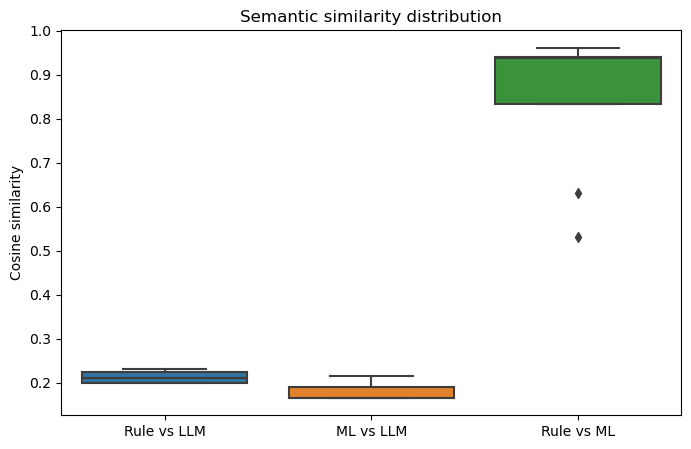

In [30]:
plt.figure(figsize=(8,5))
sns.boxplot(data=sim_df[["sim_rule_llm","sim_ml_llm","sim_rule_ml"]])
plt.xticks([0,1,2], ["Rule vs LLM","ML vs LLM","Rule vs ML"])
plt.ylabel("Cosine similarity")
plt.title("Semantic similarity distribution")
plt.show()


In [31]:
# each report with all outputs for manual inspection
for _, row in eval_df.iterrows():
    rep_id = row["report_id"]
    print("="*80)
    print(f"Report ID: {rep_id}")
    print("Report text:", row["text"])
    print("Ground truth root cause:", row["root_cause"])
    print("Rule-based cause:", row["rule_based_cause"])
    print("ML predicted cause:", model.predict(vectorizer.transform([row["clean_text"]]))[0])
    print("LLM predicted cause:", row["llm_root_cause"])
    print("LLM explanation:", row["llm_explanation"])
    # semantic sims
    sims = sim_df[sim_df["report_id"]==rep_id].iloc[0]
    print(f"Semantic sims -> rule_vs_llm: {sims['sim_rule_llm']:.3f}, ml_vs_llm: {sims['sim_ml_llm']:.3f}")
    print("\n")


Report ID: 1
Report text: Worker slipped on a wet scaffold plank due to poor housekeeping and fell 15 meters.
Ground truth root cause: Housekeeping Failure
Rule-based cause: Housekeeping Failure
ML predicted cause: Engineering Control Failure
LLM predicted cause: PPE Non-Compliance
LLM explanation: No explanation provided.
Semantic sims -> rule_vs_llm: 0.211, ml_vs_llm: 0.166


Report ID: 2
Report text: A steel beam fell because the crane operator miscommunicated with the signal person.
Ground truth root cause: Communication Failure
Rule-based cause: Communication Failure
ML predicted cause: Engineering Control Failure
LLM predicted cause: PPE Non-Compliance
LLM explanation: No explanation provided.
Semantic sims -> rule_vs_llm: 0.231, ml_vs_llm: 0.166


Report ID: 3
Report text: Electrician was shocked while repairing an energized panel without lockout-tagout.
Ground truth root cause: Procedural Failure
Rule-based cause: Procedural Failure
ML predicted cause: Procedural Failure
LLM pr

In [32]:
# Save evaluation tables
eval_df.to_csv("rca_eval_with_llm.csv", index=False)
sim_df.to_csv("rca_similarity.csv", index=False)
print("Saved results to rca_eval_with_llm.csv and rca_similarity.csv")


Saved results to rca_eval_with_llm.csv and rca_similarity.csv


## Conclusion

This notebook shows how AI can assist construction safety by:

- Extracting hazards

- Predicting root causes

- Generating explanations

- Understanding report similarity

Even with a small dataset, the workflow demonstrates the complete pipeline for developing an AI-powered accident analysis system.

## Recommendation

To improve real-world performance:

- Use 500–3,000+ real reports

- Improve prompt formatting

- Add label balancing

- Introduce fine-tuning for LLM models